# EDA: Data Insights
-------



### Notebook Summary

In this notebook, I perform EDA on a cleaned dataset of headphone products scraped from Amazon. The objective is to identify patterns and insights that are relevant for building a **content-based** recommendation system.

I begin with univariate analysis, examining each feature of the dataset individually.

From there, I will conduct multivariate analysis to uncover insights about how features are related and the strength of these relationships.


## Set Up
-----

In [95]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns


## Data Loading
----

In [96]:
df = pd.read_csv('../../data/cleaned_data.csv', index_col = 0)

## Univariate Analysis
-----

In [97]:
eda_df = df.copy()

### Checking of data types

In [98]:
eda_df.shape

(431, 13)

In [99]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, 0 to 430
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product ID        431 non-null    object 
 1   Description       431 non-null    object 
 2   Price             431 non-null    float64
 3   Rating            431 non-null    float64
 4   Is Prime          431 non-null    int64  
 5   Wireless          431 non-null    int64  
 6   Noise Cancelling  431 non-null    int64  
 7   Colour            431 non-null    object 
 8   Battery Life      431 non-null    object 
 9   Microphone        431 non-null    int64  
 10  Over Ear          431 non-null    int64  
 11  Gaming            431 non-null    int64  
 12  Foldable          431 non-null    int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 47.1+ KB


### Making Battery Life Int 

In [100]:
# Make battery life numeric, non-specified = 0
eda_df['Battery Life'] = eda_df['Battery Life'].replace('Not Specified', 0)

In [101]:
eda_df['Battery Life'] = eda_df['Battery Life'].astype(int)

### Histogram of Numerical Columns

In [102]:
num_cols = eda_df.select_dtypes(exclude='object').columns

In [103]:
num_cols

Index(['Price', 'Rating', 'Is Prime', 'Wireless', 'Noise Cancelling',
       'Battery Life', 'Microphone', 'Over Ear', 'Gaming', 'Foldable'],
      dtype='object')

In [104]:
num_cols = ['Price', 'Rating', 'Battery Life'] # Ignoring bool columns for now

In [105]:
eda_df

,Product ID,Description,Price,Rating,Is Prime,Wireless,Noise Cancelling,Colour,Battery Life,Microphone,Over Ear,Gaming,Foldable
0,B07K776ZK6,oneodio wired over ear headphones hi-fi sound ...,34.99,4.4,0,0,0,red,0,0,1,0,0
1,B074DZ39QJ,lindy nc-60 wired active noise cancelling (anc...,58.78,4.2,1,0,1,black,0,0,0,0,0
2,B00I3LUYNG,sony mdrzx310l.ae foldable headphones - metall...,18.00,4.5,0,0,0,blue,0,0,0,0,1
3,B09PQSVFQT,"kvidio bluetooth headphones over ear, 65 hours...",18.99,4.5,0,1,0,black,65,1,1,0,1
4,B00NBR70DO,"sony mdr-zx110 overhead headphones - black , b...",14.79,4.5,0,0,0,black,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,B0CPXL7VT7,"jinserta rgb cat ear headphones,bluetooth 5.3 ...",28.99,3.8,0,1,0,Not Specified,0,1,1,1,0
427,B0CCDDPS87,3.5mm earbuds wired headphones for samsung a25...,15.50,4.1,0,0,0,blue,0,0,0,0,0
428,B0CQT148LP,on ear headphones bluetooth 5.3 clip on headph...,59.99,4.4,1,1,0,Not Specified,0,0,1,0,0
429,B0D8B4W6C1,tonemac h7pro hybrid active noise cancelling h...,59.99,4.5,1,1,1,Not Specified,92,1,1,0,1


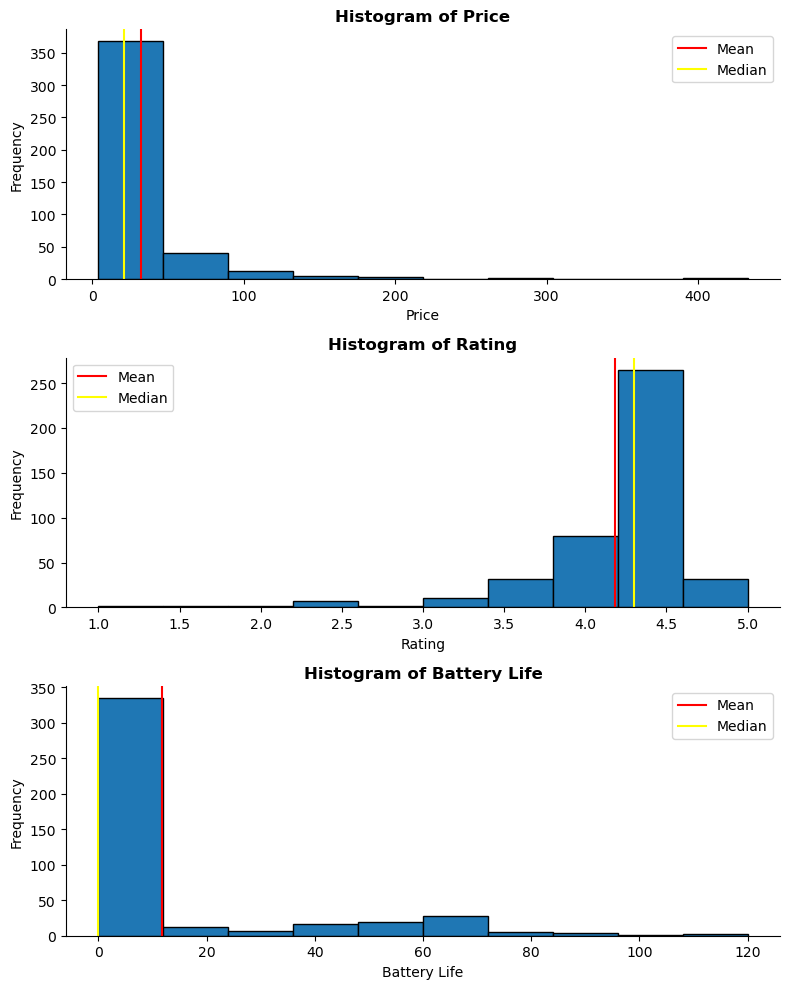

In [106]:
# Plot histogram for numerical columns
plt.figure(figsize=(8, 10))

for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 1, i+1) 
    plt.hist(eda_df[col], bins=10, edgecolor='black') 
    plt.title(f'Histogram of {col}', fontweight = 'bold')
    plt.axvline(eda_df[col].mean(), color = 'red', label = 'Mean')
    plt.axvline(eda_df[col].median(), color = 'yellow', label = 'Median')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    ax = plt.gca()

    ax.spines[['top', 'right']].set_visible(False) 

plt.tight_layout()

plt.show()

-----
**Plot Description**

***EDA: FIRST PASS (SCRAPING 30 PAGES)***


**PRICE:**
- Highly skewed to the right with the median less than the mean - the outliers (higher priced headphones) are pulling the mean to the right.
- Most products are priced less than £100 with a few pricier headphones pulling the tail to the right.
- This could lead to bias towards budget priced headphones, it may be worth performing the scraping again with more results to try even out the bias if possible.


**RATING:**
- Highly skewed to the left with most headphones having a rating above 4 out of 5 stars.
- This could be due to Amazon promoting higher-rated products more prominently on its pages. As a result, lower-rated products may not appear frequently in search results or in the first pages of results.
- The skewing and bias of ratings could hinder the recommendor system, it becomes harder to diffrentiate between good and poor quality.

**BATTERY LIFE:**

- One product has a 600-hour battery life, which seems unusually high for headphones. This might need further investigation for accuracy.
- Most headphones have a battery life less than 100 hours, which seems reasonable.
- Gaps in 70% of the data for battery life, this could limit the reliability of any insights based on battery life. May need to exlcude this feature from the recommeder system but will see if there any other better solutions.

***EDA: SECOND PASS (SCRAPING 30 PAGES)***

Similar insights as first pass:

**PRICE:**
- Data is skewed to the right, since I increased the results it is likley that the price distribution I see is representative of the headphone market on Amazon.
- Therefore I will need to transform this feature to make the distribution more normal.

**RATING:**
- Data is still skewed to the left after increasing the data, deciding not to transform the rating as this is shows the true satisfaction of users.

**BATTERY LIFE:**
- Removed the outlier of 600 hour battery life by fixing the regular expression in data-cleaning notebook.
- Since there are still a lot of data gaps in this field, I don't think it best to transform this feature. May have to think of a better way to include this feature in the recommender system.

In [107]:
# EDA: FIRST PASS (SCRAPING 30 PAGES)
# One product has a 600-hour battery life, which seems unusually high for headphones
# pd.set_option('display.max_colwidth', None)
# eda_df[eda_df['Battery Life'] > 500]['Description']
# Seems like I need to go back and fix the regexp for extracting battery life

#### Log Transformation of Price

In [108]:
eda_df['price_trans'] = np.log(eda_df['Price'])

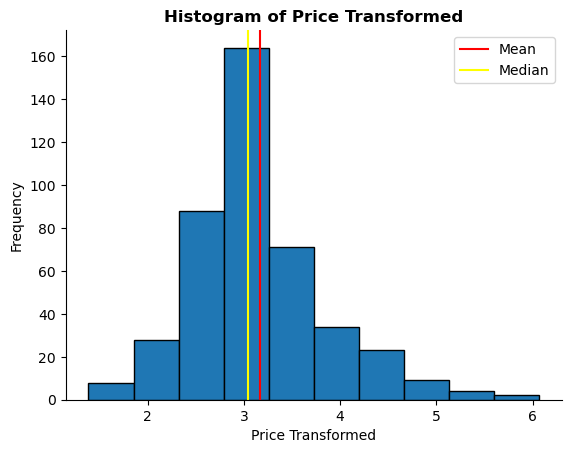

In [109]:
plt.hist(eda_df['price_trans'], bins=10, edgecolor='black')
plt.title(f'Histogram of Price Transformed', fontweight = 'bold')
plt.axvline(eda_df['price_trans'].mean(), color = 'red', label = 'Mean')
plt.axvline(eda_df['price_trans'].median(), color = 'yellow', label = 'Median')
plt.xlabel('Price Transformed')
plt.ylabel('Frequency')
plt.legend()
ax = plt.gca()

ax.spines[['top', 'right']].set_visible(False) 

plt.show()

### Bar Charts for Boolean Columns

In [110]:
# selecting only boolean columns
bool_cols = ['Is Prime', 'Wireless', 'Noise Cancelling', 'Microphone', 'Over Ear', 'Gaming', 'Foldable']

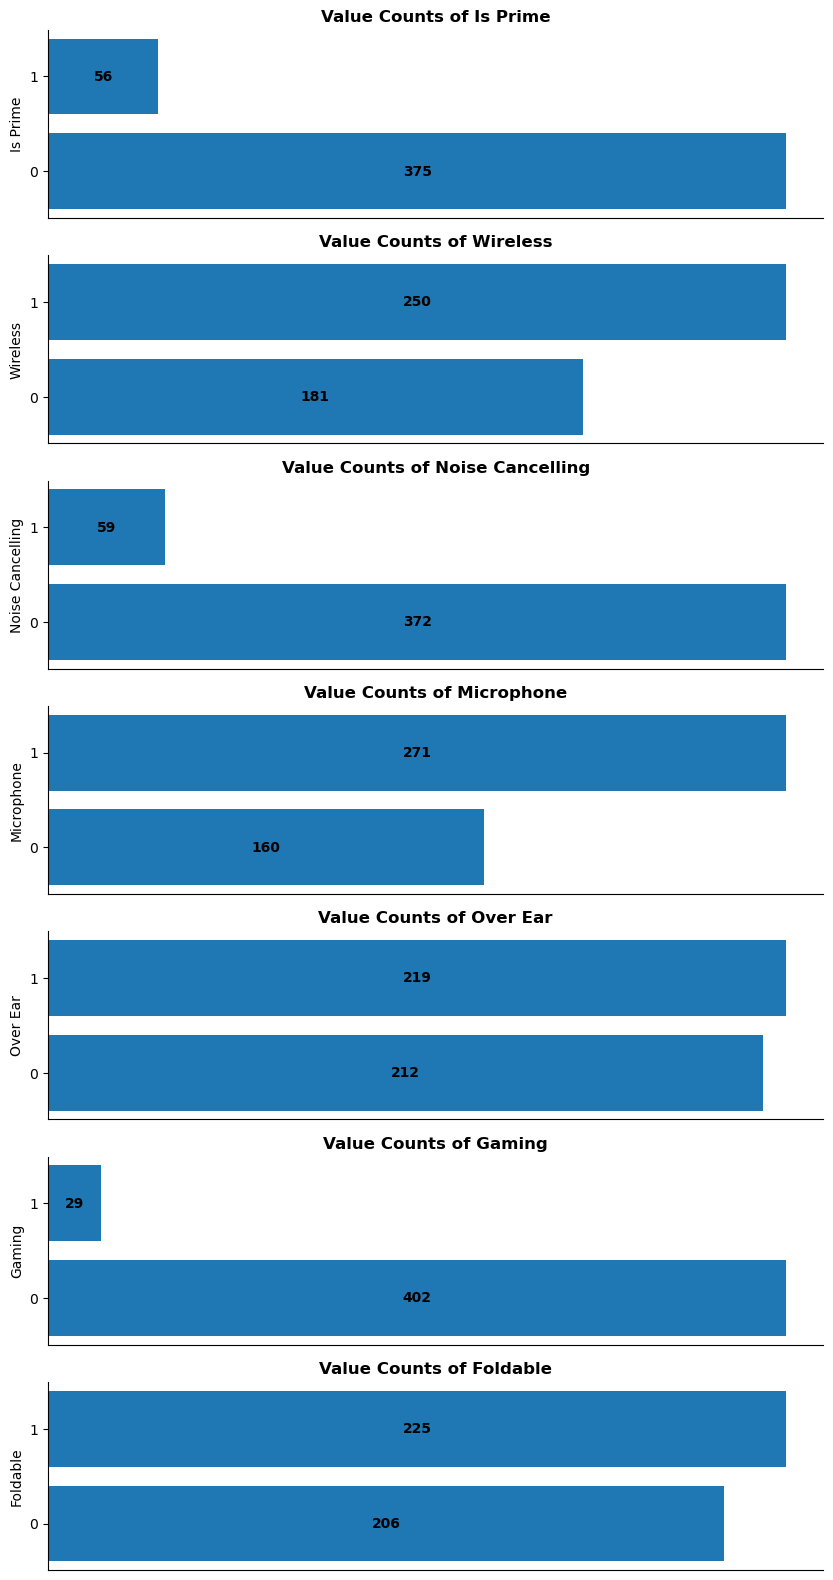

In [111]:
plt.figure(figsize=(10, 20)) 

for i, col in enumerate(bool_cols):
    plt.subplot(len(bool_cols), 1, i+1) 
    plt.barh(eda_df[col].value_counts().index, eda_df[col].value_counts().values)
    # '#1f77b4' default matplotlib colour to maintain same colour scheme throughout notebook
    plt.bar_label(plt.barh(eda_df[col].value_counts().index, eda_df[col].value_counts().values, color = '#1f77b4'), label_type='center', fontweight = 'bold')
    plt.title(f'Value Counts of {col}', fontweight = 'bold')
    plt.xticks([])
    plt.yticks([0,1])
    plt.ylabel (f'{col}')
    ax = plt.gca()

    ax.spines[['top', 'right']].set_visible(False) 

plt.show()

------
**Plot Description:**

***EDA: FIRST PASS (SCRAPING 30 PAGES)***

**Is Prime**
- Clear class imbalance with most headohones having prime eligibility
- Since most of the products are Prime, it may not add much to the recommeder system and may need to be weighted less in the model.


**Wireless** 
- Less of a class imbalance with a decent split between wireless and wired headphones.
- More suitable to be used in a recommeder system

**Noise Cancelling** 
- See a very strong class imbalance with most headphones not having this feature
- Since I plan to build a content based recommender system I don't see this imbalance being a big issue as the model should still prioritise noise cancelling products despite the imabalance if that what the user enters as a preference.

**Microphone**  
- Minor class imbalance, not as drastic as other features
- To keep this feature as it will be useful feature for users who are looking for headphones to use for work or gaming.

**Over Ear** 
- Almost perfect class split

**Gaming**  
- Strong class imbalance with very few gaming specific headphones
- Gaming headphones can be considered to be a niche product and isn't likley to be relevant to all users. 

**Foldable**
- Balanced split between the classes.

***EDA: FIRST PASS (SCRAPING 30 PAGES)***

Still similar imbalances in all features like seen in the first EDA pass.

At this point, I am unlikely to take any steps to address the class imbalances. Since the data was collected through scraping, I want to preserve its representation of the market. Introducing additional data to balance the classes could introduce my own biases. If possible, I will attempt to address the imbalance issues when building the recommender.

### Bar Chart for Category Columns

In [112]:
cat_cols = eda_df.select_dtypes(include = 'object').columns

In [113]:
cat_cols # only really want colour

Index(['Product ID', 'Description', 'Colour'], dtype='object')

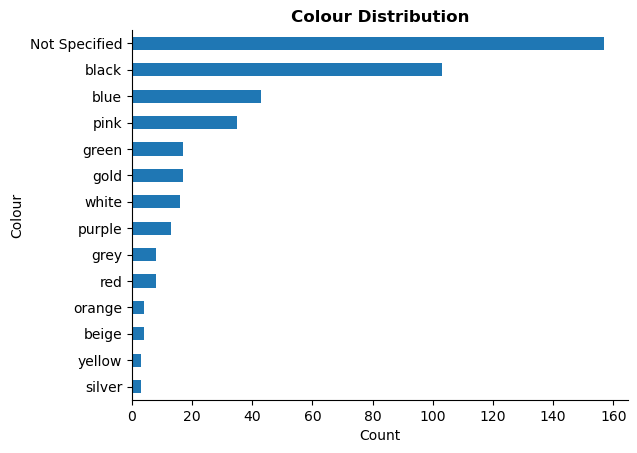

In [114]:
eda_df['Colour'].value_counts().sort_values(ascending=True).plot(kind = 'barh')
ax = plt.gca()
ax.spines[['top','right']].set_visible(False)
ax.set_title('Colour Distribution', fontweight = 'bold')
ax.set_xlabel('Count')
plt.show()

----
**Plot Description:**

***EDA: FIRST PASS (SCRAPING 30 PAGES)***

**Not Specified:** 

The largest proportion of headphones do not have a colour specified in the product description. This feature may not be one that is common to add to the product description?

**Popular Colors:**

- *Black*: The most popular colour choice, suggesting that black headphones are a preferred colour.
- *Blue* and *Pink*: These colours are also popular.

**Less Common Colors:**

- Colours such as *White*, *Green* and *Gold* show a lower presence, suggesting these colours are a less common choice.
- Colours like *Purple*, *Grey*, *Red* and others show an even lower presence.

***EDA: SECOND PASS (SCRAPING 50 PAGES)***

Similar findngs to first pass.

#### Grouping of Least Popular Colours 

In [115]:
# To first put least popular colours in other category (reduce column explosion on encoding)
df['Colour'].value_counts()

Colour
Not Specified    157
black            103
blue              43
pink              35
gold              17
green             17
white             16
purple            13
red                8
grey               8
beige              4
orange             4
silver             3
yellow             3
Name: count, dtype: int64

In [116]:
# Deciding to remove grouping of Other
# If value counts of colour is less than 10, category will be other
# colours_to_grp = df['Colour'].value_counts() < 10

In [117]:
# Deciding to remove grouping of Other
# colours_to_grp = df['Colour'].value_counts() < 10
# eda_df['Colour'] = eda_df['Colour'].replace(colours_to_grp[colours_to_grp].index, 'Other')

-----
**Comment:**

After building the Streamlit application, I realised that having an Other category in the Colour could lead to confusion. Given that the dataset is not too large, I decided to remove this grouping and display all extracted colors. 

#### Encoding of Colour

In [118]:
from sklearn.preprocessing import OneHotEncoder

In [119]:
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(eda_df[['Colour']])
colour_df = pd.DataFrame(one_hot_encoded.toarray(),columns = encoder.get_feature_names_out(['Colour']), index= eda_df.index)

In [120]:
colour_df.shape

(431, 14)

In [121]:

eda_df_final = pd.concat([eda_df, colour_df], axis=1)

eda_df_final = eda_df_final.drop(columns=['Colour'])

In [122]:
eda_df_final.columns

Index(['Product ID', 'Description', 'Price', 'Rating', 'Is Prime', 'Wireless',
       'Noise Cancelling', 'Battery Life', 'Microphone', 'Over Ear', 'Gaming',
       'Foldable', 'price_trans', 'Colour_Not Specified', 'Colour_beige',
       'Colour_black', 'Colour_blue', 'Colour_gold', 'Colour_green',
       'Colour_grey', 'Colour_orange', 'Colour_pink', 'Colour_purple',
       'Colour_red', 'Colour_silver', 'Colour_white', 'Colour_yellow'],
      dtype='object')

In [123]:
eda_df.shape

(431, 14)

In [124]:
eda_df_final.shape

(431, 27)

----
**Comment:**

Deciding to rerun the scraping increasing pages from 30 to 50 pages of results from the results of the univariate analysis. 

If I still see skewness in the data after this (highly likley) I will transform the data before moving to the multivariate analysis.


## Multivariate Anlaysis
-----

Using data from second scraping pass (50 pages)

### Pair Plot of Numeric Columns

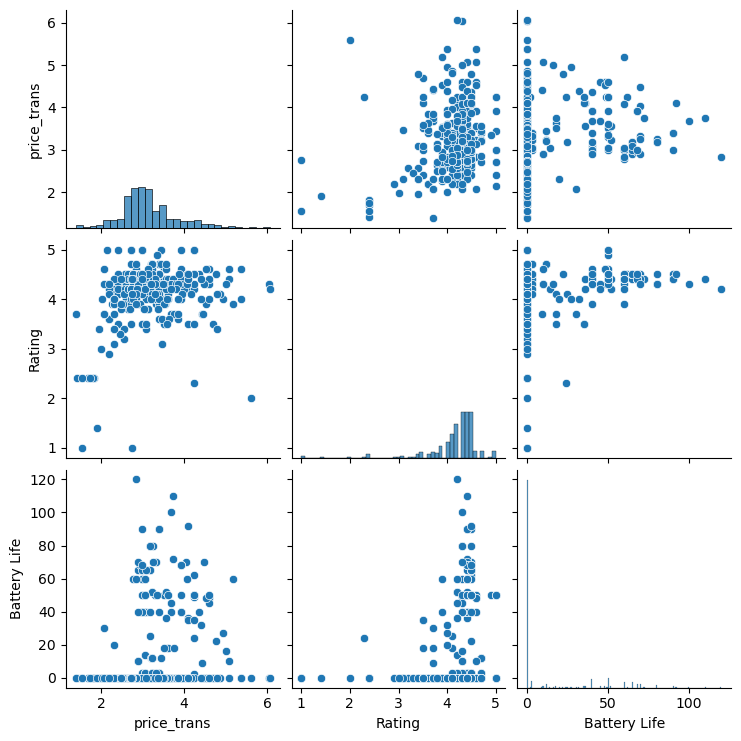

In [125]:
# Selecting most important numeric columns for pairplot
sns.pairplot(eda_df_final[['price_trans', 'Rating', 'Battery Life']])
plt.show()


-----
**Plot Description:**

Here, I am looking to see if any of the numerical columns are highly correlated with each other.

It seems as if there isn't a strong linear correlation between any features meaning the changes of one feature is not reflected in another. 

This may be due to the limiations of craeting a dataset from webscraping. Amazon likely uses algorithms that influence which products are displayed in search results. This could introduce biases into the dataset and this is what we may be seeing here. To use a correlation matrix to check findings.

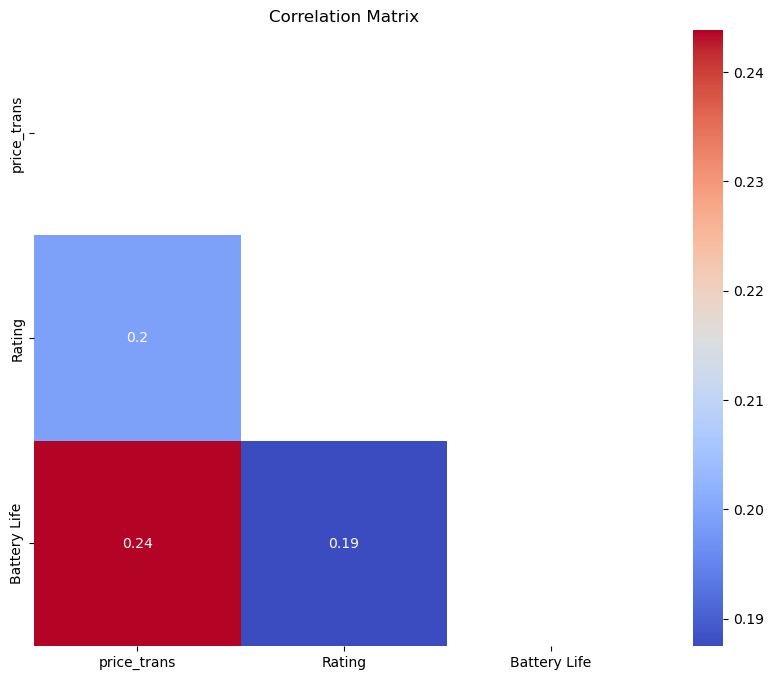

In [126]:
corr = eda_df_final[['price_trans', 'Rating', 'Battery Life']].corr()
mask =- np.triu(corr)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix')
plt.show()

----
**Plot Description:**

The correlation matrix also shows there is very weak correlation between the numeric features.

### Boolean Columns with Price: Box Plots

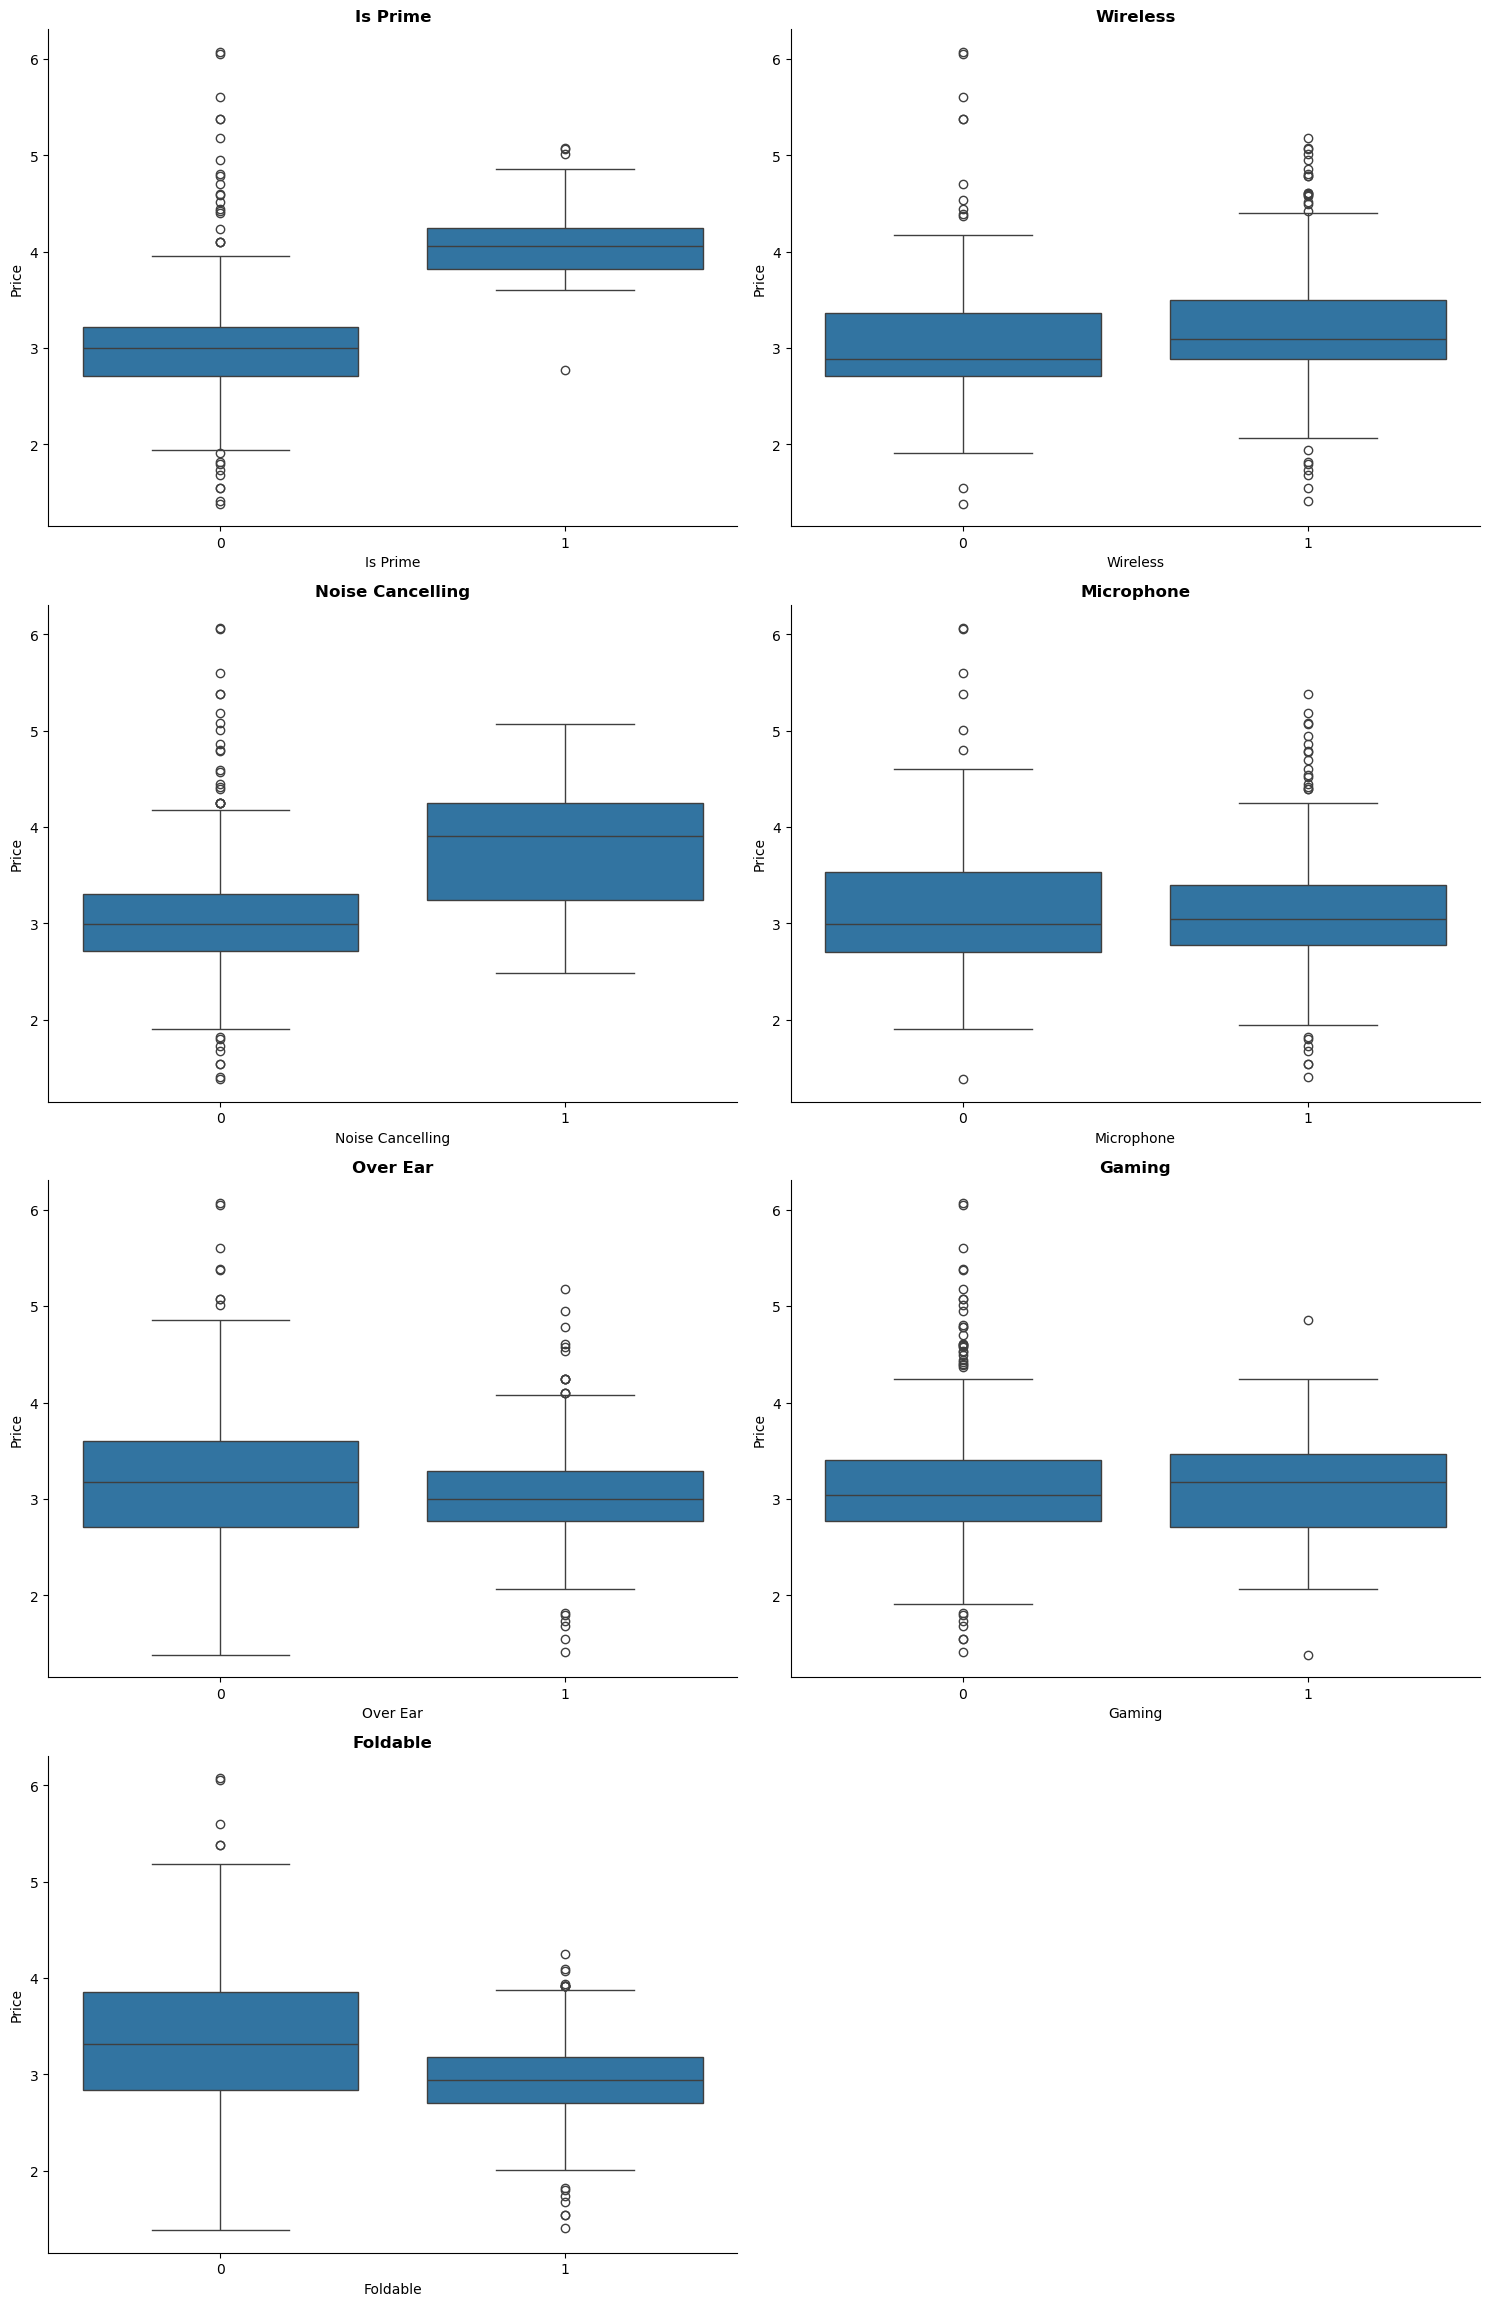

In [127]:
plt.figure(figsize=(15, 40)) 

for i, col in enumerate(bool_cols):
    plt.subplot(len(bool_cols), 2, i + 1)  
    sns.boxplot(x=col, y='price_trans', data=eda_df_final) 
    plt.title(f'{col}', fontweight='bold') 
    plt.xlabel(col)  
    plt.ylabel('Price')  
    ax = plt.gca()
    ax.spines[['top', 'right']].set_visible(False) 

plt.tight_layout() 
plt.show()  

----
**Plot Description:**

Note since I have not yet dealt with the class imbalances, the insights could be skewed. 

**Is Prime**
- Prime products tend to be more expensive on average than non-prime products.
- There are more outliers in non-prime products, indicating more price variation.

**Wireless** 
- The average price of wired and wireless headphones appears to be similar.

**Noise Cancelling** 
- Noise-cancelling headphones are more expensive on average than non-noise-cancelling models, which is expected given that noise-cancellation is often considered a premium feature.
-There are more outliers in the non-noise-cancelling group, possibly due to other features that affect price.

**Microphone**  
- Headphones with microphones tend to be slightly cheaper than those without
- The presence of many outliers in headphones with microphones suggests other headphone features influence price more.

**Over Ear** 
- Over-ear headphones are slighlt lower priced on average than in-ear headphones.

**Gaming**  
- Gaming and non-gaming headphones share smiliar prices with non-gaming have more outliers. 

**Foldable**
- Non-foldable headphones are more expensive on average than foldable ones.

### Boolean Columns with Rating: Box Plots

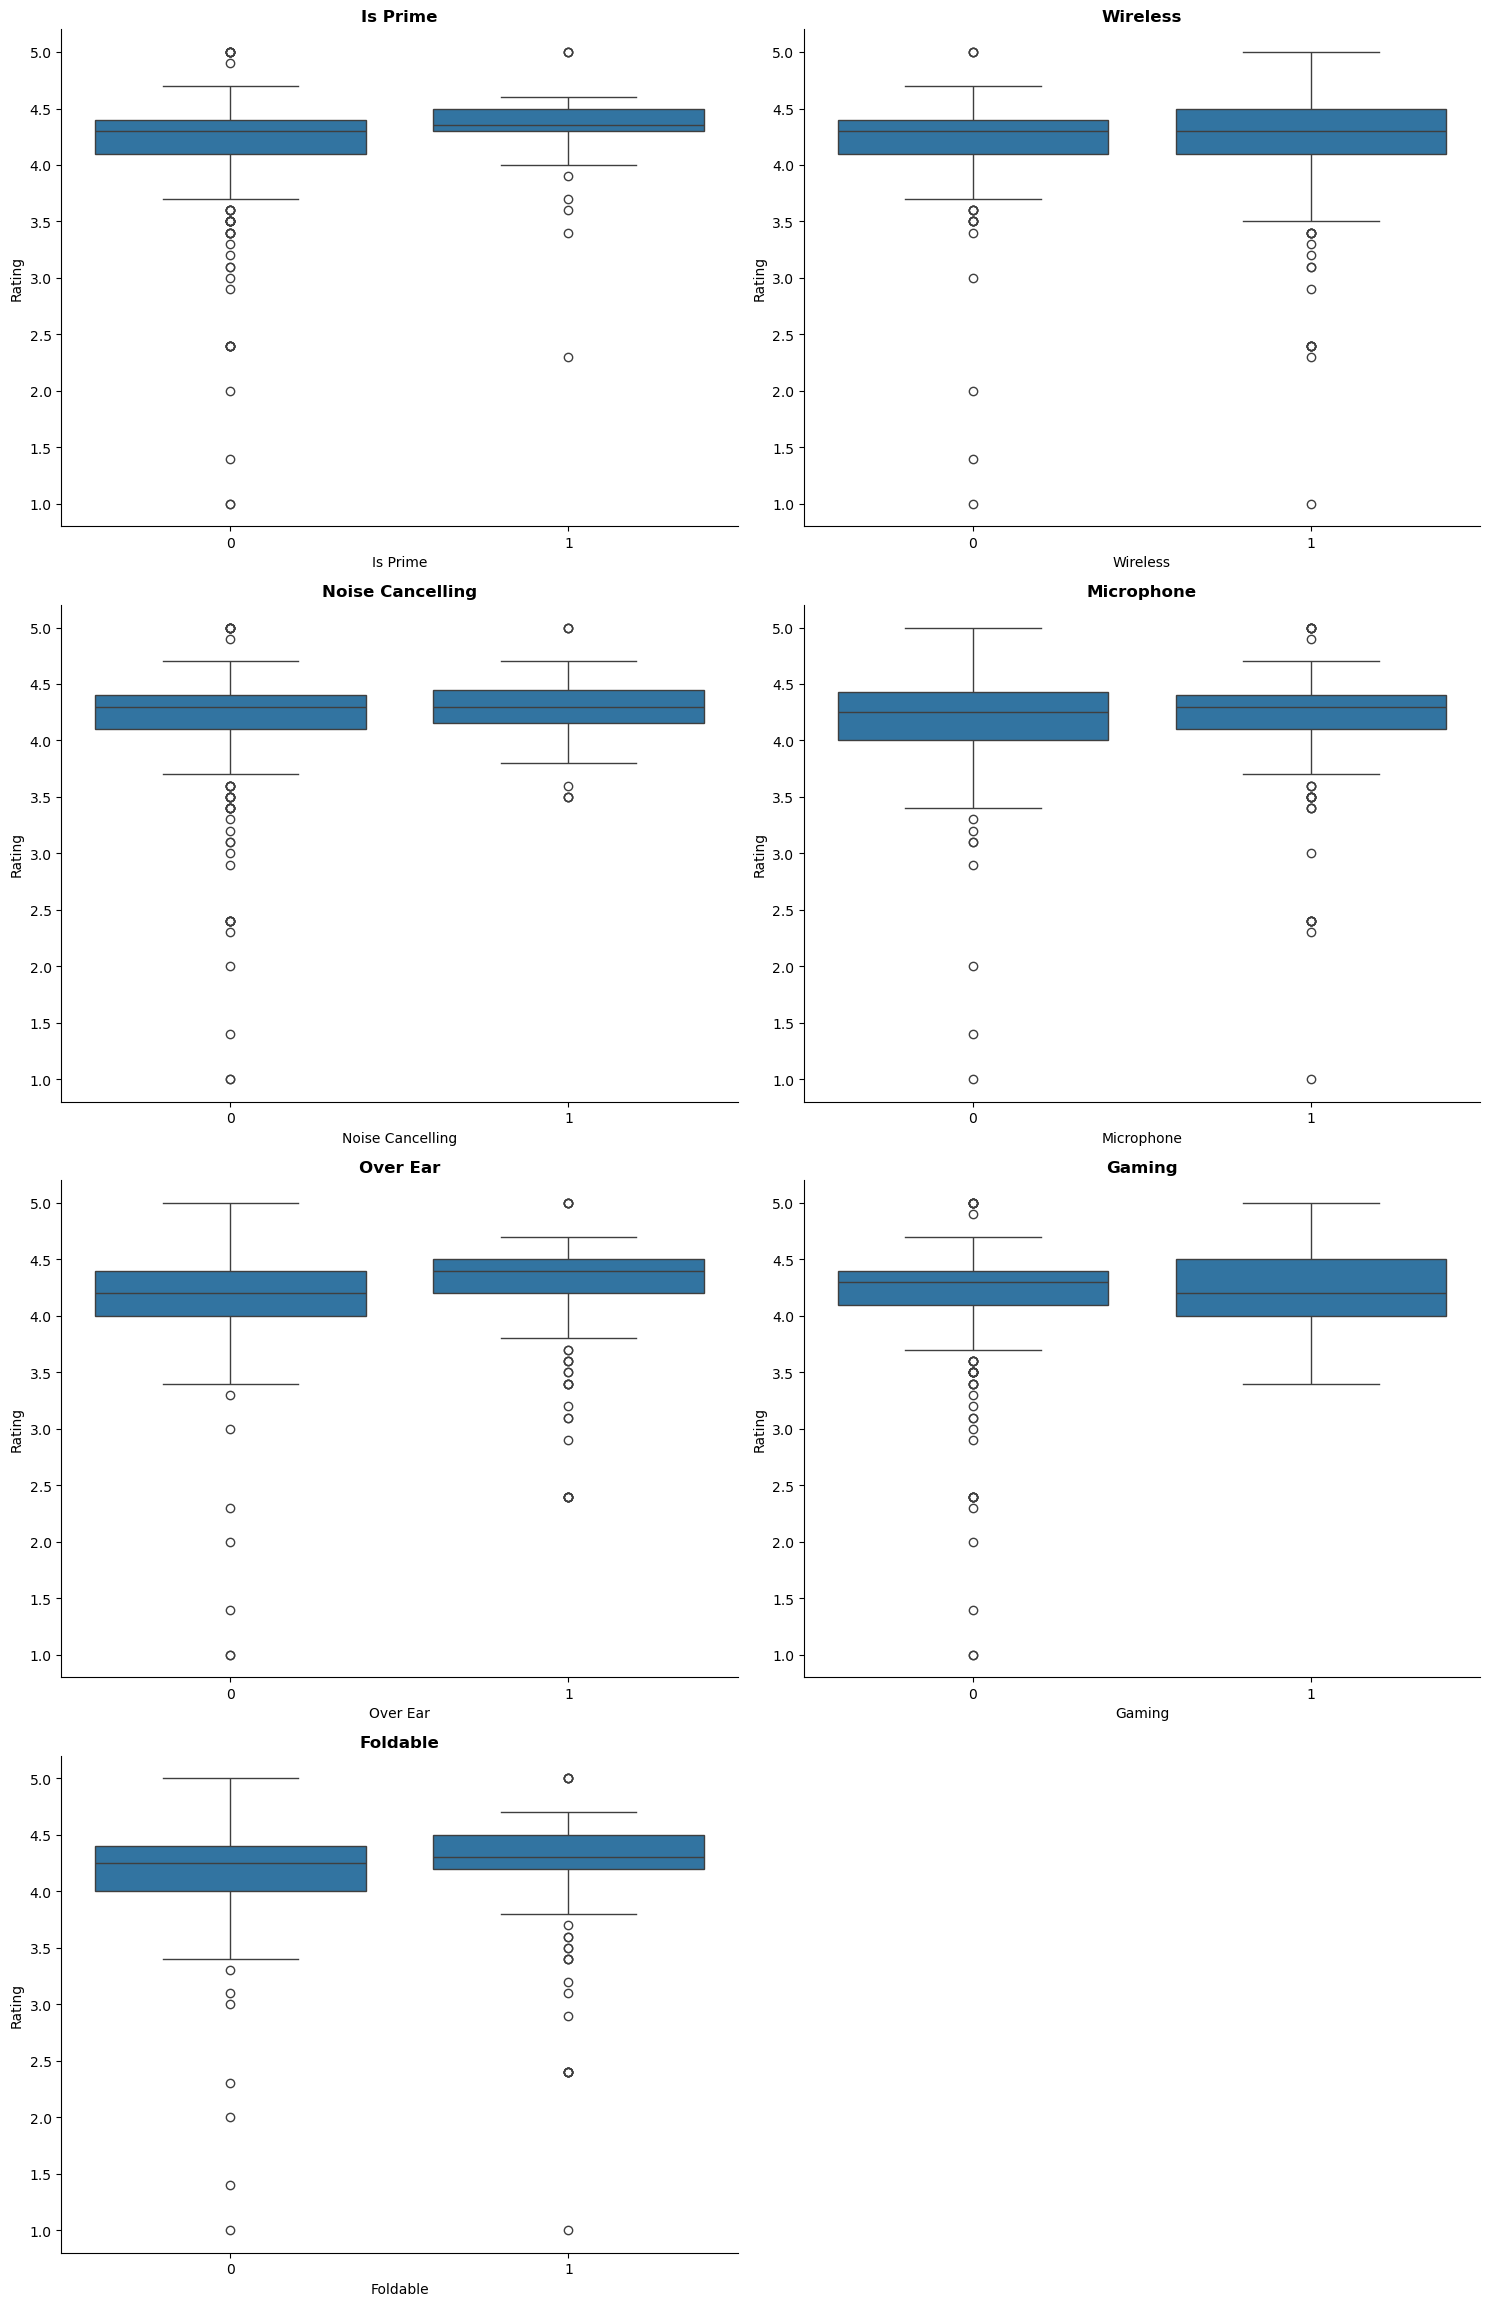

In [128]:
plt.figure(figsize=(15, 40)) 

# Loop through each boolean column
for i, col in enumerate(bool_cols):
    plt.subplot(len(bool_cols), 2, i + 1)
    sns.boxplot(x=col, y='Rating', data=eda_df) 
    plt.title(f'{col}', fontweight='bold')  
    plt.xlabel(col)  # Set x-label
    plt.ylabel('Rating')  # Set y-label

    ax = plt.gca()
    ax.spines[['top', 'right']].set_visible(False) 

plt.tight_layout() 
plt.show()

----
**Plot Description:**

There isn't much difference in the average ratings between the classes for most features. This could be due to the high proportion of high ratings in the dataset, which makes it harder to observe differences across the different features.


### Colours Against Price

In [129]:
colour_cols = []    
for col in eda_df_final.columns:
    if col.startswith('Colour_'):
        col = col.replace('Colour_', '')
        colour_cols.append(col)

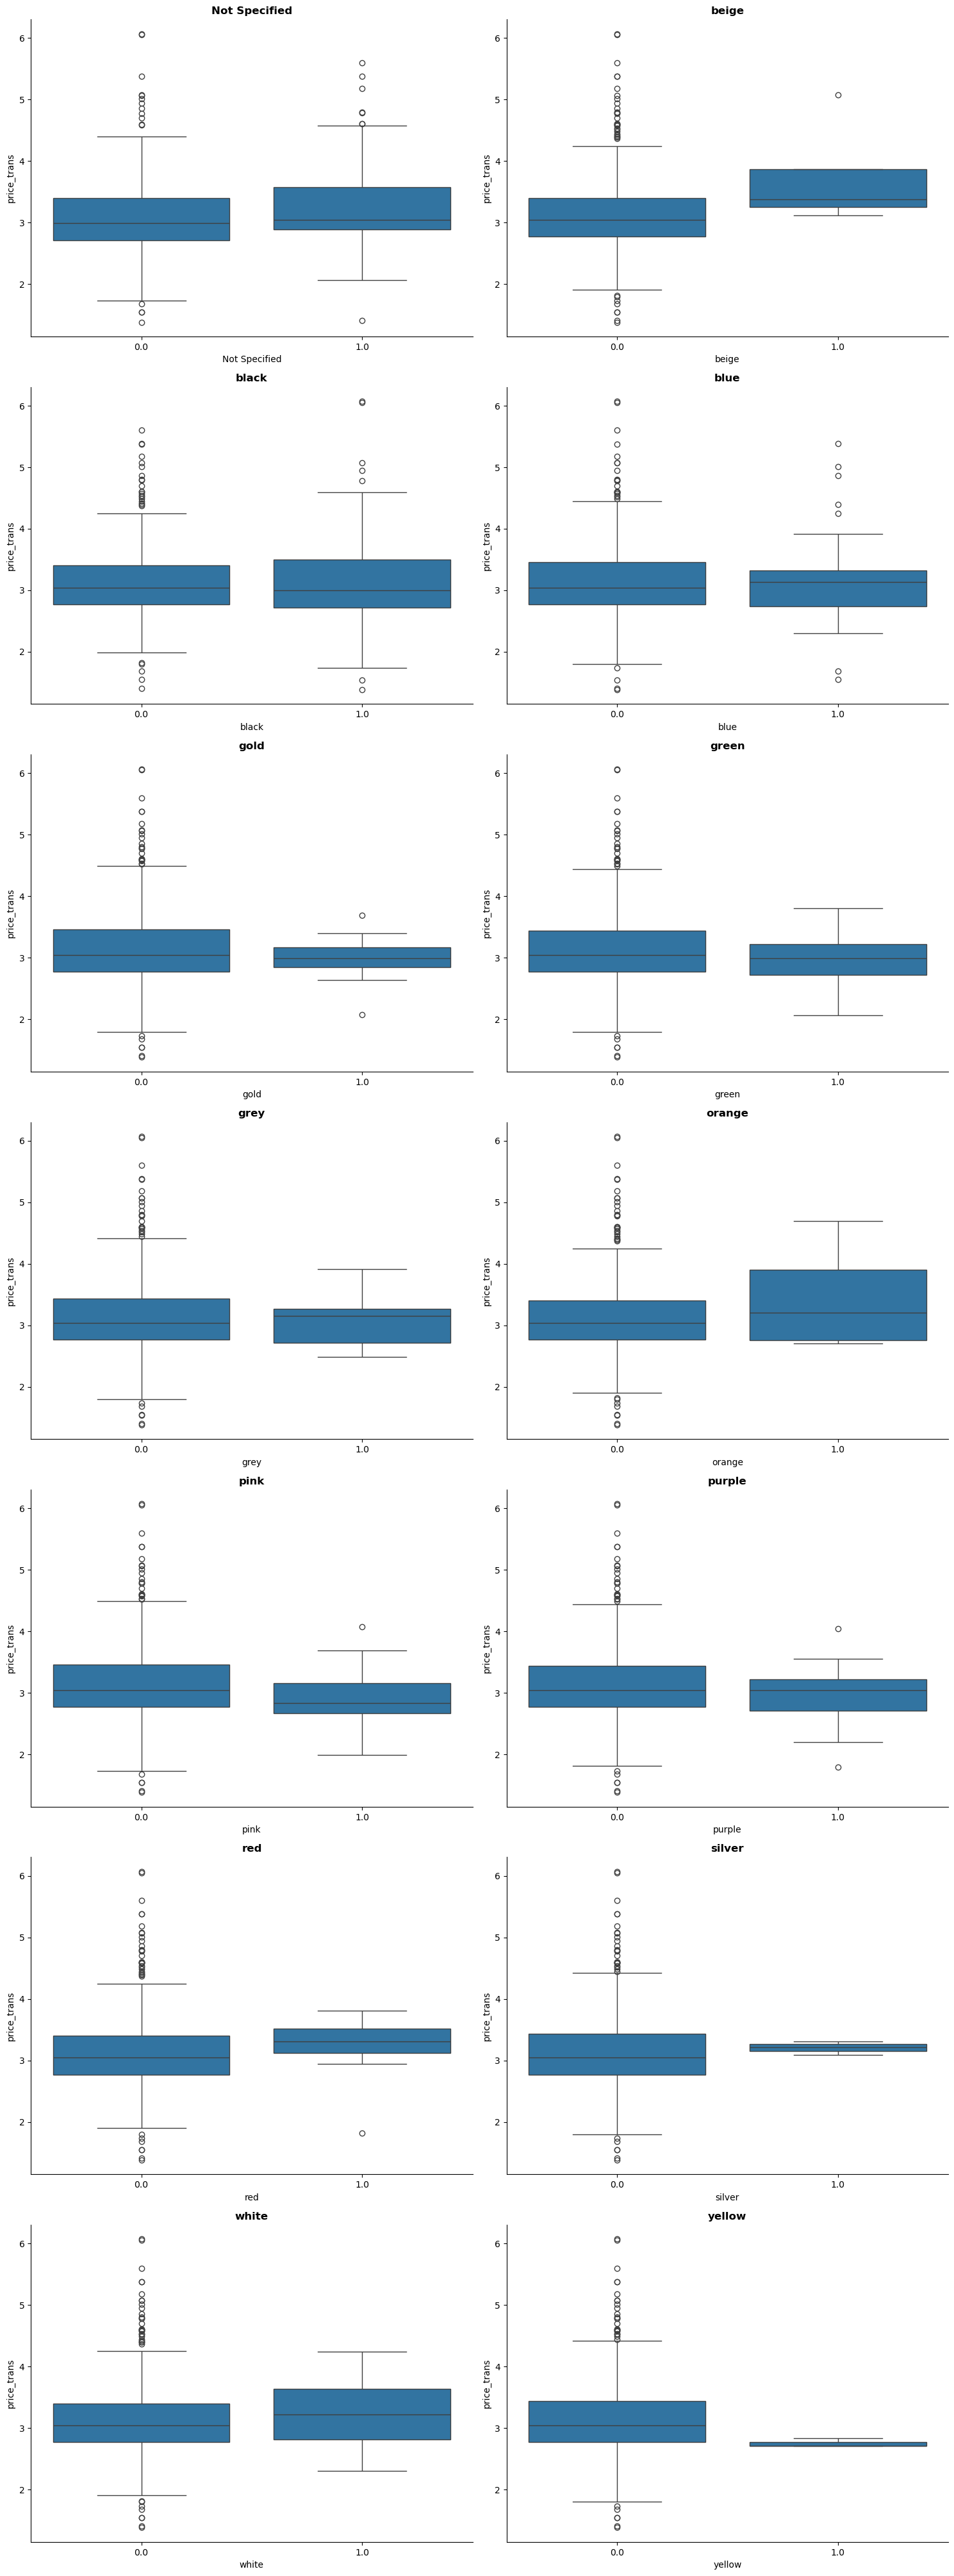

In [130]:
plt.figure(figsize=(15, 80)) 

for i, col in enumerate(colour_cols):
    plt.subplot(len(colour_cols), 2, i + 1)  
    sns.boxplot(x='Colour_' + col, y='price_trans', data=eda_df_final) 
    plt.title(f'{col}', fontweight='bold') 
    plt.xlabel(col)  
    plt.ylabel('price_trans')  
    ax = plt.gca()
    ax.spines[['top', 'right']].set_visible(False) 

plt.tight_layout() 
plt.show()  

-----
**Plot Description:**

Minimal differences in price across the different colours, indicating that headphone colour has a minimal affect on headphone price. However, I have decided to include colour as a feature in the recommender system, as I think it is a significant aspect of user preference. 


## Correlation with Price/Rating
-----

In [131]:
# assessing corr with all columns but product id and description
cols = eda_df_final.columns.drop(['Product ID', 'Description', 'Price'])

### Price (price_trans)

In [132]:
# Calculate correlation with price
corr = eda_df_final[cols].corr()
price_corr = corr[['price_trans']].sort_values(by= 'price_trans', ascending=False)

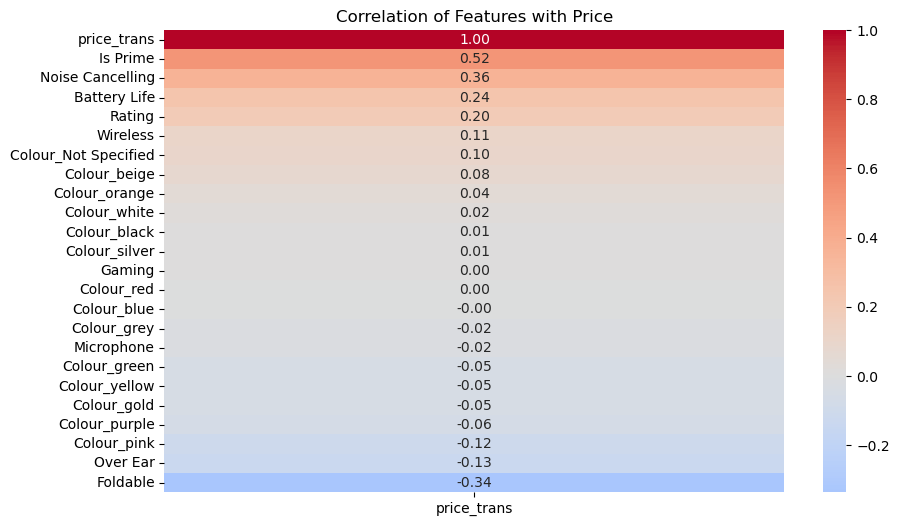

In [133]:

plt.figure(figsize=(10, 6))  
sns.heatmap(price_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)  
plt.title('Correlation of Features with Price')  
plt.show()

----
**Comment:**

It is clear that Prime Eligibility and Foldable are the features that influence price the most.

Prime products show a significant increase in price of headphones, perhaps due faster shipping. 

Foldable headphones shows a negative correlation, suggesting that this feature may be associated with lower pricing. This could indicate that foldable design is  found in budget friendly headphones.

In addition, while noise-cancelling features also have a moderate positive correlation with price suggseting it is a more premium headphone feature.

Headphone colour, gaming capability and microphone presence all show minimal influence. This may reflect the class imbalance observed in the dataset, where certain features are underrepresented.

### Rating

In [134]:
# Calculate correlation with price
corr = eda_df_final[cols].corr()
corr[['Rating']].sort_values(by= 'Rating', ascending=False)

,Rating
Rating,1.000000
price_trans,0.199140
Battery Life,0.187492
Is Prime,0.094307
Colour_green,0.084808
Over Ear,0.084662
Foldable,0.075056
Noise Cancelling,0.074784
Colour_Not Specified,0.067876
Colour_gold,0.065157


-----
**Comment:**

With ratings the correlation of features becomes weaker, this may be due to the over-representation we have in the data set of highly-reviewd headphones. As a result, it becomes challenging to determine which specific features are most strongly associated with higher or lower ratings.

## Exporting eda_df to CSV
----

In [135]:
eda_df_final.shape

(431, 27)

In [137]:
eda_df[eda_df['Product ID'].duplicated()]

,Product ID,Description,Price,Rating,Is Prime,Wireless,Noise Cancelling,Colour,Battery Life,Microphone,Over Ear,Gaming,Foldable,price_trans


In [138]:
eda_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, 0 to 430
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product ID            431 non-null    object 
 1   Description           431 non-null    object 
 2   Price                 431 non-null    float64
 3   Rating                431 non-null    float64
 4   Is Prime              431 non-null    int64  
 5   Wireless              431 non-null    int64  
 6   Noise Cancelling      431 non-null    int64  
 7   Battery Life          431 non-null    int64  
 8   Microphone            431 non-null    int64  
 9   Over Ear              431 non-null    int64  
 10  Gaming                431 non-null    int64  
 11  Foldable              431 non-null    int64  
 12  price_trans           431 non-null    float64
 13  Colour_Not Specified  431 non-null    float64
 14  Colour_beige          431 non-null    float64
 15  Colour_black          431 no

In [140]:
eda_df_final.to_csv('../../data/final_data.csv')

## Conclusion
-----

Overall, the EDA has provided valuable insights into the features of the headphone dataset.

By assessing each feature individually, I identified class imbalances and skewness in the data. This is particularly important as I transition to modelling, as I have taken and will continue to take steps to ensure these issues do not affect the reliability of my model.

Through the multivariate analysis, I determined which features have the greatest influence on headphone prices.

These insights will be valuable as I move forward in building a recommendation system tailored to user preferences.